In [1]:
import sys
sys.path.append("../")

In [2]:
import torch
from samplers.ParallelTempering import parallel_tempering_step
import numpy as np
from utils import GMM, quadratic_function, MC_estimate_true_expectation, relative_mae, plot_contours
from mmd import MMD_loss

device = torch.device('cuda')
torch.set_default_tensor_type('torch.FloatTensor')

/scratches/gauss/wc337/miniconda3/envs/rdgs/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


True Expectation: 1791.9268


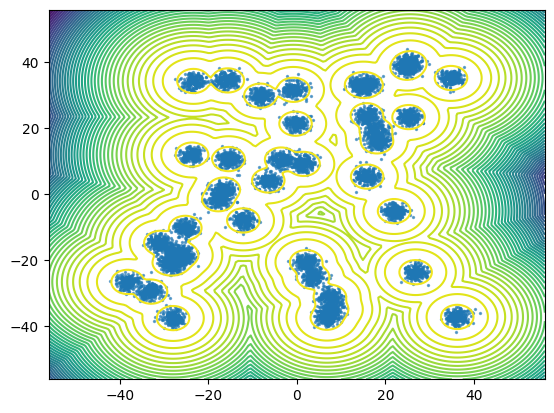

In [3]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              device=device)

energy = lambda x: -target.log_prob(x)

plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)

n_samples = int(1e4)
true_samples = target.sample([n_samples])
plot_contours(target.log_prob, samples=true_samples.cpu().numpy(), bounds=plotting_bounds, n_contour_levels=50, grid_width_n_points=200, device=device, plt_show=False)

true_expectation = MC_estimate_true_expectation(true_samples.cpu(), quadratic_function)
print("True Expectation:", true_expectation.cpu().numpy())

In [4]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

Temperatures: [1.0, 5.62, 31.62, 177.83, 1000.0]


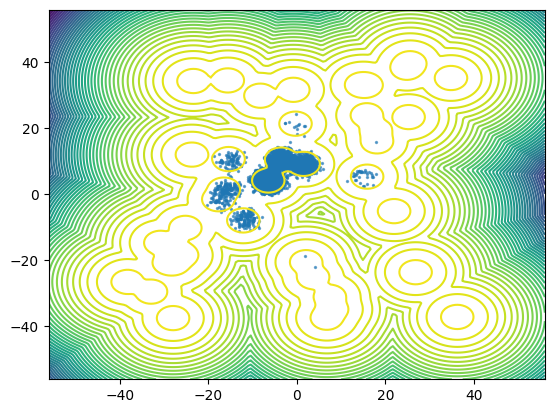

Expectation: 59.49305
Relative MAE: 0.9667993783950806
MMD: 1.9331203699111938


In [5]:
num_samples=10000
step_size = 1e-1
num_leapfrog_steps_per_hmc_step = 20
num_hmc_steps = 10

# (inverse) temperature schedule
num_chains = 5
inv_temperatures = [0.0] * num_chains
b_min = 0.001

for r in range(num_chains):
    t = r / (num_chains - 1)
    inv_temperatures[r] = b_min ** t
print("Temperatures:", [round(1.0/inv_t, 2) for inv_t in inv_temperatures])

x = [torch.zeros([num_samples, dim], device=device) for _ in range(num_chains)]

energy = lambda x: -target.log_prob(x)

chains = parallel_tempering_step(x, num_chains, energy, step_size, num_leapfrog_steps_per_hmc_step, num_hmc_steps, inv_temperatures, device)
x = chains[0]
plot_contours(target.log_prob, samples=x.cpu().numpy(), bounds=plotting_bounds, n_contour_levels=50, grid_width_n_points=200, device=device, plt_show=True)

expectation = MC_estimate_true_expectation(x.cpu(), quadratic_function)
print("Expectation:", expectation.cpu().numpy())

print("Relative MAE:", relative_mae(true_expectation, expectation).item())

mmd_loss=MMD_loss(kernel_num=5)
mmd=mmd_loss.forward(source=x.cpu(), target=true_samples.cpu())
print("MMD:", mmd.item())